# Project 8 Uber data = May 2014 #

In [ ]:
!pip install folium

In [ ]:
!pip install -U scikit-fuzzy

In [106]:
import numpy as np
import pandas as pd
import random
from random import sample

import folium

from bokeh.io import output_notebook
output_notebook()
bokeh_width, bokeh_height = 500,400
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

from PIL import Image, ImageDraw

%matplotlib inline

import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN

from sklearn import mixture #Gaussian Mixture Modelling
from sklearn.mixture import GaussianMixture
from skfuzzy.cluster import cmeans, cmeans_predict #fuzzy clustering

from datetime import datetime

Loading BokehJS ...

In [25]:
uber_raw = pd.read_csv(r'C:\Users\borys\IronHack\Project_8_Uber\uber-raw-data-may14.csv')
uber_raw.head()

,Date/Time,Lat,Lon,Base
0,5/1/2014 0:02:00,40.7521,-73.9914,B02512
1,5/1/2014 0:06:00,40.6965,-73.9715,B02512
2,5/1/2014 0:15:00,40.7464,-73.9838,B02512
3,5/1/2014 0:17:00,40.7463,-74.0011,B02512
4,5/1/2014 0:17:00,40.7594,-73.9734,B02512


In [26]:
uber_raw.shape

(652435, 4)

In [27]:
uber_raw.isnull().sum()

Date/Time    0
Lat          0
Lon          0
Base         0
dtype: int64

In [28]:
uber_raw.dtypes

Date/Time     object
Lat          float64
Lon          float64
Base          object
dtype: object

In [29]:
uber_raw.columns

Index(['Date/Time', 'Lat', 'Lon', 'Base'], dtype='object')

In [30]:
uber = uber_raw.drop('Base', axis=1)

In [31]:
uber.columns

Index(['Date/Time', 'Lat', 'Lon'], dtype='object')

In [32]:
uber.dtypes

Date/Time     object
Lat          float64
Lon          float64
dtype: object

In [33]:
#as our data are too big, we want to get a sample of @ 50K rows for future visualisation and analysis

uber_sample = uber.sample(frac =.0766362)

uber_sample

,Date/Time,Lat,Lon
593245,5/23/2014 18:48:00,40.7740,-73.8719
504623,5/12/2014 7:18:00,40.6800,-73.9843
452278,5/5/2014 9:25:00,40.7204,-73.9966
518302,5/14/2014 9:28:00,40.6963,-73.8435
444753,5/3/2014 22:24:00,40.7213,-73.9881
...,...,...,...
121103,5/10/2014 21:01:00,40.7388,-74.0088
507095,5/12/2014 15:56:00,40.7586,-73.9724
183844,5/17/2014 20:51:00,40.7095,-74.0173
240727,5/24/2014 11:46:00,40.7309,-74.0029


In [34]:
from datetime import datetime
 
uber_sample['date'] = pd.DatetimeIndex(uber_sample['Date/Time']).date
uber_sample['time'] = pd.DatetimeIndex(uber_sample['Date/Time']).hour
 
#changing into categories of day and night
uber_sample['day-night'] = pd.cut(x=uber_sample['time'],
                              bins = [0,10,15,19,24],
                              labels = ['Morning','Afternoon','Evening','Night'])

uber_sample

,Date/Time,Lat,Lon,date,time,day-night
593245,5/23/2014 18:48:00,40.7740,-73.8719,2014-05-23,18,Evening
504623,5/12/2014 7:18:00,40.6800,-73.9843,2014-05-12,7,Morning
452278,5/5/2014 9:25:00,40.7204,-73.9966,2014-05-05,9,Morning
518302,5/14/2014 9:28:00,40.6963,-73.8435,2014-05-14,9,Morning
444753,5/3/2014 22:24:00,40.7213,-73.9881,2014-05-03,22,Night
...,...,...,...,...,...,...
121103,5/10/2014 21:01:00,40.7388,-74.0088,2014-05-10,21,Night
507095,5/12/2014 15:56:00,40.7586,-73.9724,2014-05-12,15,Afternoon
183844,5/17/2014 20:51:00,40.7095,-74.0173,2014-05-17,20,Night
240727,5/24/2014 11:46:00,40.7309,-74.0029,2014-05-24,11,Afternoon


In [35]:
uber_sample2 = uber_sample

In [36]:
uber_sample2.columns

Index(['Date/Time', 'Lat', 'Lon', 'date', 'time', 'day-night'], dtype='object')

In [37]:
uber_sample2

,Date/Time,Lat,Lon,date,time,day-night
593245,5/23/2014 18:48:00,40.7740,-73.8719,2014-05-23,18,Evening
504623,5/12/2014 7:18:00,40.6800,-73.9843,2014-05-12,7,Morning
452278,5/5/2014 9:25:00,40.7204,-73.9966,2014-05-05,9,Morning
518302,5/14/2014 9:28:00,40.6963,-73.8435,2014-05-14,9,Morning
444753,5/3/2014 22:24:00,40.7213,-73.9881,2014-05-03,22,Night
...,...,...,...,...,...,...
121103,5/10/2014 21:01:00,40.7388,-74.0088,2014-05-10,21,Night
507095,5/12/2014 15:56:00,40.7586,-73.9724,2014-05-12,15,Afternoon
183844,5/17/2014 20:51:00,40.7095,-74.0173,2014-05-17,20,Night
240727,5/24/2014 11:46:00,40.7309,-74.0029,2014-05-24,11,Afternoon


# Visualisations #

c:\Users\borys\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Morning'),
  Text(1, 0, 'Afternoon'),
  Text(2, 0, 'Evening'),
  Text(3, 0, 'Night')])

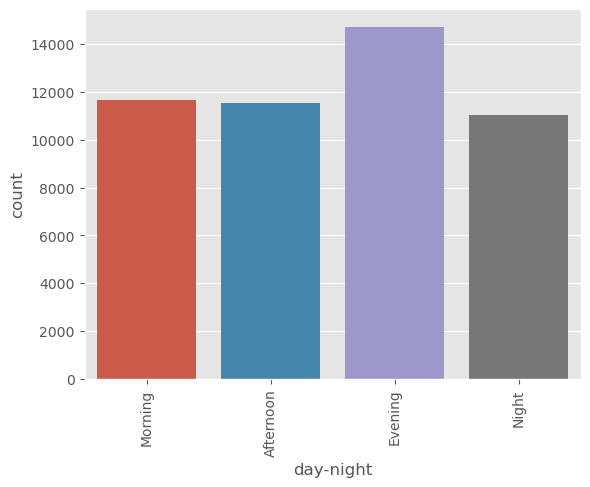

In [38]:
sns.countplot(uber_sample2['day-night'])
plt.xticks(rotation=90)

In [39]:
uber_sample2.columns

Index(['Date/Time', 'Lat', 'Lon', 'date', 'time', 'day-night'], dtype='object')

In [52]:
uber_sample3 = uber_sample2.drop(['Date/Time','date','day-night'], axis=1)
uber_sample3

,Lat,Lon,time
593245,40.7740,-73.8719,18
504623,40.6800,-73.9843,7
452278,40.7204,-73.9966,9
518302,40.6963,-73.8435,9
444753,40.7213,-73.9881,22
...,...,...,...
121103,40.7388,-74.0088,21
507095,40.7586,-73.9724,15
183844,40.7095,-74.0173,20
240727,40.7309,-74.0029,11


In [53]:
uber_sample3 = uber_sample3.apply(pd.to_numeric)
uber_sample3.dtypes

Lat     float64
Lon     float64
time      int64
dtype: object

# Visualisation of Sample using some map #

In [48]:
#Center for our future map / Manhattan / New York
map = folium.Map(location=[uber_sample.Lat.mean(), uber_sample.Lon.mean()], zoom_start=14, control_scale=True)

In [49]:
#for index, location_info in bike_station_locations.iterrows():
#    folium.Marker([location_info["Latitude"], location_info["Longitude"]], popup=location_info["Name"]).add_to(map)

# Data Clustering #

In [50]:
# delete worthless columns and convert others into appropriate types
uber_sample3.Lat = pd.to_numeric(uber_sample3.Lat, errors='ignore')
uber_sample3.Lon = pd.to_numeric(uber_sample3.Lon, errors='ignore')
uber_sample3.time = pd.to_timedelta(uber_sample3.time)

In [54]:
# create 5 dataframes for each six-hour (quarters) time spans and All

uber_sample3_q0 = uber_sample3.loc[(uber_sample3.time >= 0) & (uber_sample3.time < 6), ['Lat', 'Lon']]
uber_sample3_q1 = uber_sample3.loc[(uber_sample3.time >= 6) & (uber_sample3.time < 12), ['Lat', 'Lon']]
uber_sample3_q2 = uber_sample3.loc[(uber_sample3.time >= 12) & (uber_sample3.time < 18), ['Lat', 'Lon']]
uber_sample3_q3 = uber_sample3.loc[uber_sample3.time >= 18, ['Lat', 'Lon']]
uber_sample3 = uber_sample3.loc[:, ['Lat', 'Lon']]

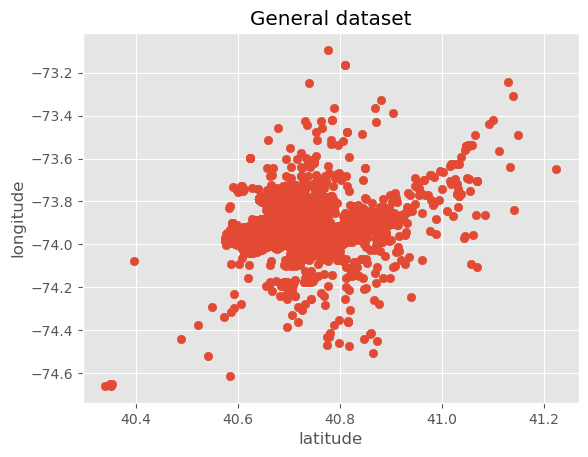

In [55]:
#General distribution plot

plt.scatter(uber_sample3.Lat, uber_sample3.Lon)
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title('General dataset')
plt.show()

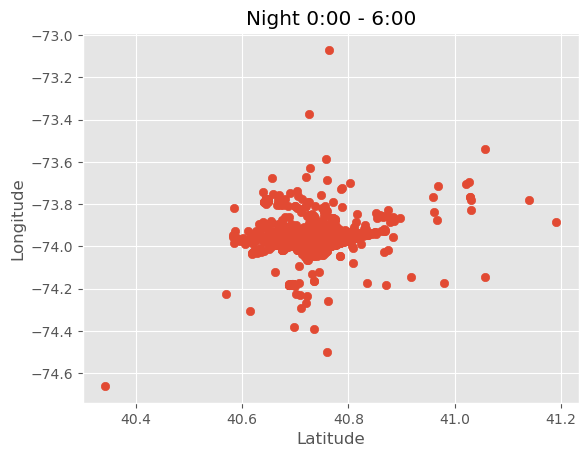

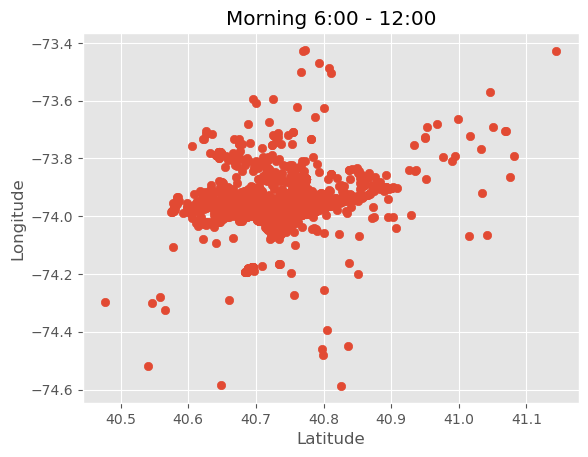

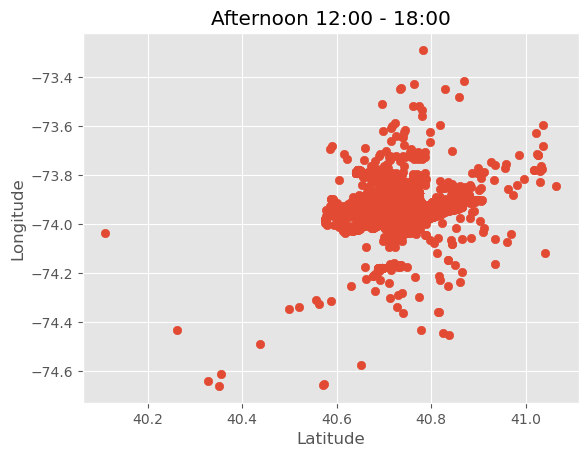

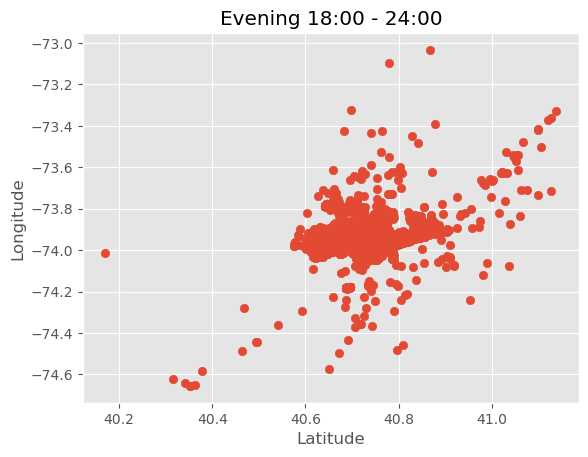

In [ ]:
#Distribution plots for each quarter

#First quarter (0:00 - 6:00)
plt.scatter(uber_sample3_q0.Lat, uber_sample3_q0.Lon)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Night 0:00 - 6:00')
plt.show()

#Second quarter (6:00 - 12:00)

plt.scatter(uber_sample3_q1.Lat, uber_sample3_q1.Lon)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Morning 6:00 - 12:00')
plt.show()

#Third quarter (12:00 - 18:00)
plt.scatter(uber_sample3_q2.Lat, uber_sample3_q2.Lon)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Afternoon 12:00 - 18:00')
plt.show()

#The last quarter (18:00 - 24:00)
plt.scatter(uber_sample3_q3.Lat, uber_sample3_q3.Lon)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Evening 18:00 - 24:00')
plt.show()


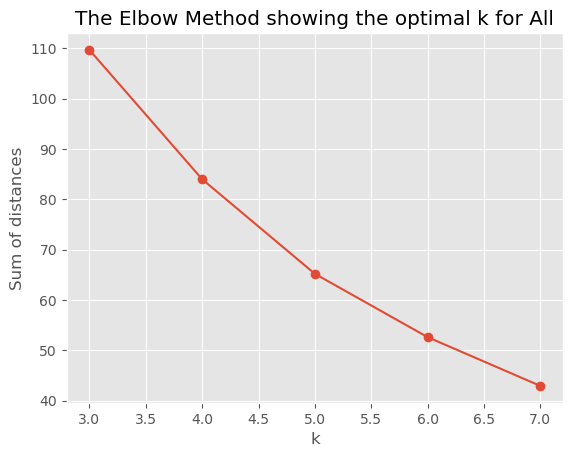

In [ ]:
#Elbow method for optimal clusters number for All data

K = range(3, 8)
models = [KMeans(n_clusters=k, random_state=123).fit(uber_sample3) for k in K]
dist = [model.inertia_ for model in models]

# Plot the elbow
plt.plot(K, dist, marker='o')
plt.xlabel('k')
plt.ylabel('Sum of distances')
plt.title('The Elbow Method showing the optimal k for All')
plt.show()

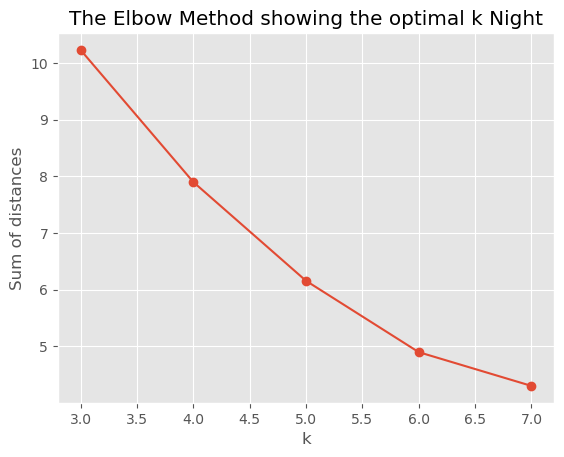

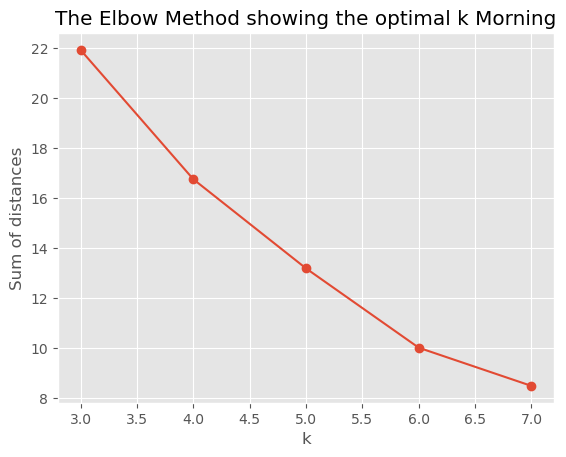

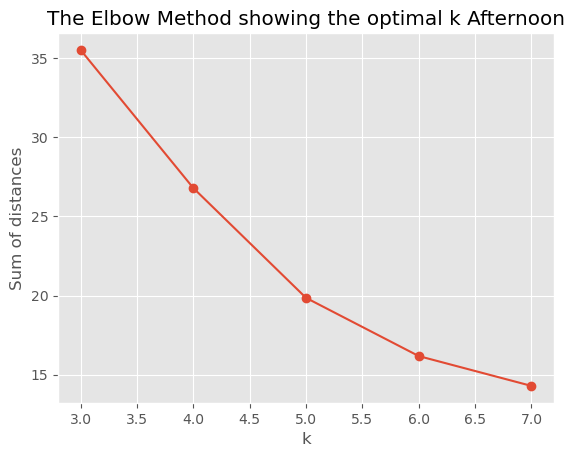

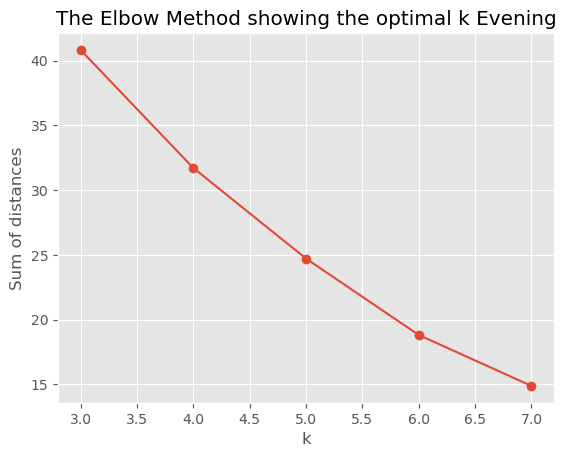

In [ ]:
#Elbow method for optimal clusters number for Each Quarter

models = [KMeans(n_clusters=k, random_state=123).fit(uber_sample3_q0) for k in range(3, 8)]
dist = [model.inertia_ for model in models]
plt.plot(K, dist, marker='o')
plt.xlabel('k')
plt.ylabel('Sum of distances')
plt.title('The Elbow Method showing the optimal k Night')
plt.show()

models = [KMeans(n_clusters=k, random_state=123).fit(uber_sample3_q1) for k in range(3, 8)]
dist = [model.inertia_ for model in models]
plt.plot(K, dist, marker='o')
plt.xlabel('k')
plt.ylabel('Sum of distances')
plt.title('The Elbow Method showing the optimal k Morning')
plt.show()

models = [KMeans(n_clusters=k, random_state=123).fit(uber_sample3_q2) for k in range(3, 8)]
dist = [model.inertia_ for model in models]
plt.plot(K, dist, marker='o')
plt.xlabel('k')
plt.ylabel('Sum of distances')
plt.title('The Elbow Method showing the optimal k Afternoon')
plt.show()

models = [KMeans(n_clusters=k, random_state=123).fit(uber_sample3_q3) for k in range(3, 8)]
dist = [model.inertia_ for model in models]
plt.plot(K, dist, marker='o')
plt.xlabel('k')
plt.ylabel('Sum of distances')
plt.title('The Elbow Method showing the optimal k Evening')
plt.show()

# K-means clustering #

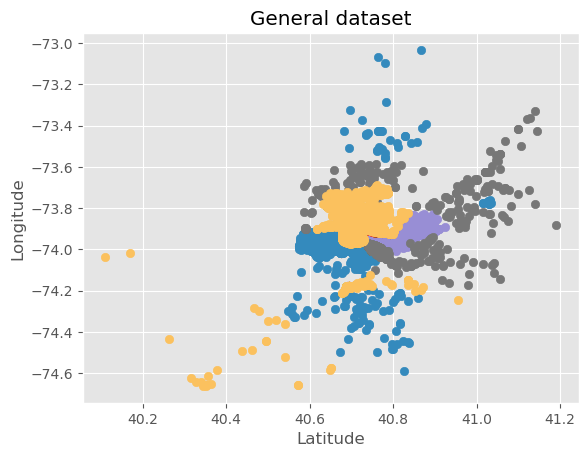

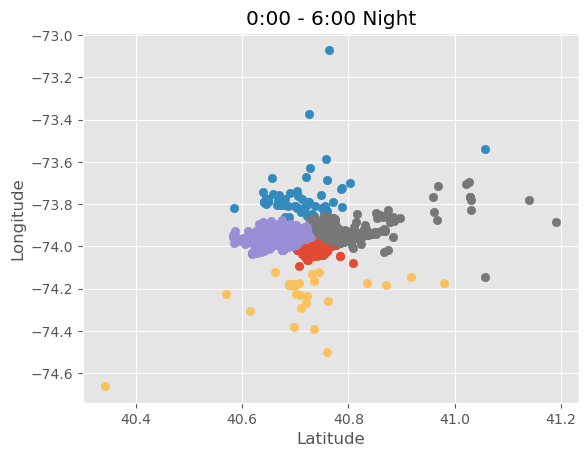

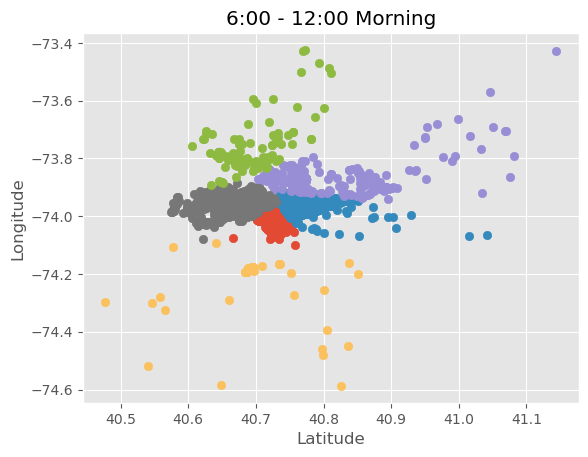

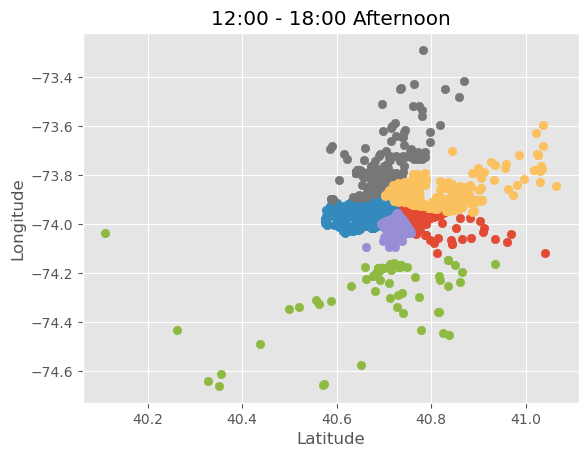

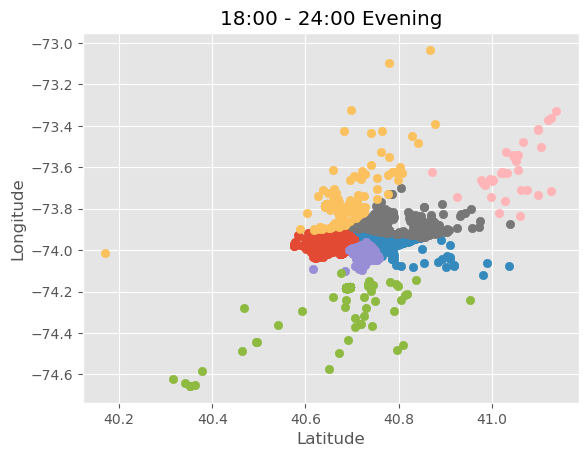

In [ ]:
#For all data

model_gen = KMeans(n_clusters=5, random_state=123)
labels_gen = model_gen.fit(uber_sample3)
uber_sample3['cluster'] = model_gen.labels_
for i in uber_sample3['cluster'].unique():
    plt.scatter(uber_sample3[uber_sample3['cluster']==i].Lat, uber_sample3[uber_sample3['cluster']==i].Lon, label = i)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('General dataset')
plt.show()

model_q0 = KMeans(n_clusters=5, random_state=123)
labels_q0 = model_q0.fit(uber_sample3_q0)
uber_sample3_q0['cluster'] = model_q0.labels_
for i in uber_sample3_q0['cluster'].unique():
    plt.scatter(uber_sample3_q0[uber_sample3_q0['cluster']==i].Lat, uber_sample3_q0[uber_sample3_q0['cluster']==i].Lon, label = i)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('0:00 - 6:00 Night')
plt.show()

model_q1 = KMeans(n_clusters=6, random_state=123)
labels_q1 = model_q1.fit(uber_sample3_q1)
uber_sample3_q1['cluster'] = model_q1.labels_
for i in uber_sample3_q1['cluster'].unique():
    plt.scatter(uber_sample3_q1[uber_sample3_q1['cluster']==i].Lat, uber_sample3_q1[uber_sample3_q1['cluster']==i].Lon, label = i)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('6:00 - 12:00 Morning')
plt.show()

model_q2 = KMeans(n_clusters=6, random_state=123)
labels_q2 = model_q2.fit(uber_sample3_q2)
uber_sample3_q2['cluster'] = model_q2.labels_
for i in uber_sample3_q2['cluster'].unique():
    plt.scatter(uber_sample3_q2[uber_sample3_q2['cluster']==i].Lat, uber_sample3_q2[uber_sample3_q2['cluster']==i].Lon, label = i)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('12:00 - 18:00 Afternoon')
plt.show()

model_q3 = KMeans(n_clusters=7, random_state=123)
labels_q3 = model_q3.fit(uber_sample3_q3)
uber_sample3_q3['cluster'] = model_q3.labels_
for i in uber_sample3_q3['cluster'].unique():
    plt.scatter(uber_sample3_q3[uber_sample3_q3['cluster']==i].Lat, uber_sample3_q3[uber_sample3_q3['cluster']==i].Lon, label = i)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('18:00 - 24:00 Evening')
plt.show()

In [ ]:
# Create map visualization
new_york = folium.Map(location = [40.7, -74.0], zoom_start = 11)
events = folium.map.FeatureGroup()

# Add markers for general data and each time quarter to map
def add_markers(model, info, color):    
    positions = model.cluster_centers_
    latitudes = [lat[0] for lat in positions]
    longitudes = [lon[1] for lon in positions]
    for lat, lon in zip(latitudes, longitudes):
        folium.Marker([lat, lon], popup=info, icon=folium.Icon(color=color)).add_to(new_york)
        
add_markers(model_gen, 'General data', 'blue')     
add_markers(model_q0, 'Night', 'red')     
add_markers(model_q1, 'Morning', 'green')     
add_markers(model_q2, 'Afternoon', 'orange')     
add_markers(model_q3, 'Evening', 'darkblue')     

new_york.add_child(events)

# DBSCAN method #

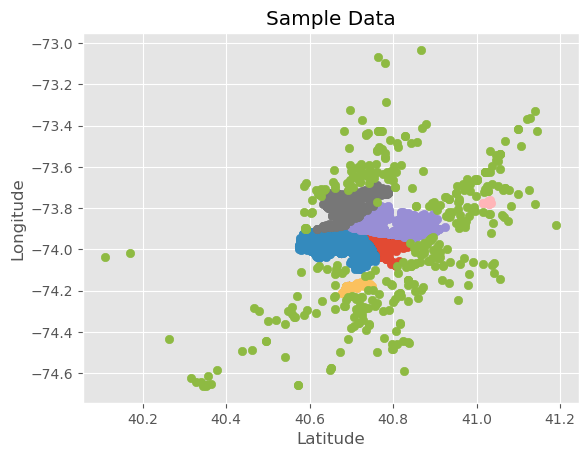

In [ ]:
# Trying DBSCAN algorithm for clustering
dbscan = DBSCAN(eps=0.02, min_samples=10).fit(uber_sample3)
uber_sample3['cluster'] = dbscan.labels_
for i in uber_sample3['cluster'].unique():
    plt.scatter(uber_sample3[uber_sample3['cluster']==i].Lat, uber_sample3[uber_sample3['cluster']==i].Lon, label = i)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Sample Data')
plt.show()

In [ ]:
# Count the number of clusters and noise
n_clusters_ = len(set(uber_sample3['cluster'])) - (1 if -1 in uber_sample3['cluster'] else 0)
n_noise_ = list(uber_sample3['cluster']).count(-1)
print("Number of clusters: ",n_clusters_)

Number of clusters:  5


# Modelling #

In [69]:
clus_fuz_ori = uber[['Lat', 'Lon']]

In [79]:
fpcs_ori = [5]

n_cluster = 5

In [81]:
cntr_ori, u_orig, _, _, _, _, _ = cmeans(clus_fuz_ori.T, 5, 2 , error=0.01, maxiter=1000)

In [82]:
u_ori, u0, d, jm, p, pc = cmeans_predict(clus_fuz_ori.T, cntr_ori, 2 , error=0.01, maxiter=1000)

In [83]:
centroids_fuz_ori = cntr_ori
centroids_fuz_ori

array([[ 40.77757058, -73.95414295],
       [ 40.65569828, -73.78482668],
       [ 40.75633399, -73.98090979],
       [ 40.68949641, -73.96986073],
       [ 40.72761885, -73.99966197]])

In [84]:
clocation_fuz_ori = pd.DataFrame(centroids_fuz_ori, columns = ['Latitude', 'Longitude'])
clocation_fuz_ori

,Latitude,Longitude
0,40.777571,-73.954143
1,40.655698,-73.784827
2,40.756334,-73.980910
3,40.689496,-73.969861
4,40.727619,-73.999662


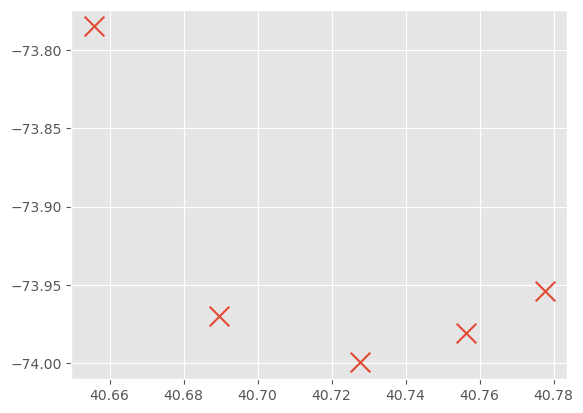

In [88]:
plt.scatter(clocation_fuz_ori['Latitude'], clocation_fuz_ori['Longitude'], marker = "x", s = 200)

In [89]:
centroid_fuz_ori = clocation_fuz_ori.values.tolist()

map_fuz_ori = folium.Map(location = [40.71600413400166, -73.98971408426613], zoom_start = 10)
for point in range(0, len(centroid_fuz_ori)):
    folium.Marker(centroid_fuz_ori[point], popup = centroid_fuz_ori[point]).add_to(map_fuz_ori)

map_fuz_ori

# Gaussian Mixture #

In [70]:
clus_gmm_ori = uber[['Lat', 'Lon']]

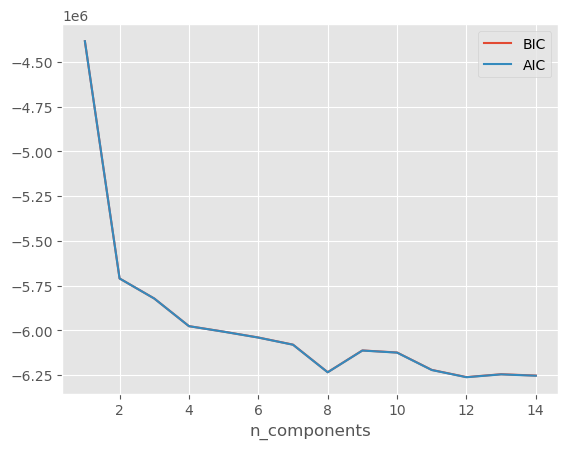

In [64]:
#n_components = np.arange(1, 15)
#models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(clus_gmm_ori) for n in n_components]
#plt.plot(n_components, [m.bic(clus_gmm_ori) for m in models], label='BIC')
#plt.plot(n_components, [m.aic(clus_gmm_ori) for m in models], label='AIC')
#plt.legend(loc='best')
#plt.xlabel('n_components');

In [65]:
clf = mixture.GaussianMixture(n_components=4, covariance_type='full')
clf.fit(clus_gmm_ori)

GaussianMixture(n_components=4)

In [59]:
label_gmm_ori = clf.predict(clus_gmm_ori)

In [60]:
df_new_gmm = uber.copy()
df_new_gmm['Clusters'] = label_gmm_ori
df_new_gmm

,Date/Time,Lat,Lon,Clusters
0,5/1/2014 0:02:00,40.7521,-73.9914,3
1,5/1/2014 0:06:00,40.6965,-73.9715,2
2,5/1/2014 0:15:00,40.7464,-73.9838,3
3,5/1/2014 0:17:00,40.7463,-74.0011,3
4,5/1/2014 0:17:00,40.7594,-73.9734,0
...,...,...,...,...
652430,5/31/2014 23:45:00,40.7309,-74.0014,3
652431,5/31/2014 23:52:00,40.7528,-73.9798,0
652432,5/31/2014 23:55:00,40.7158,-73.9519,2
652433,5/31/2014 23:56:00,40.6961,-73.8997,1


In [61]:
df_new_gmm['Clusters'].unique()

array([3, 2, 0, 1], dtype=int64)

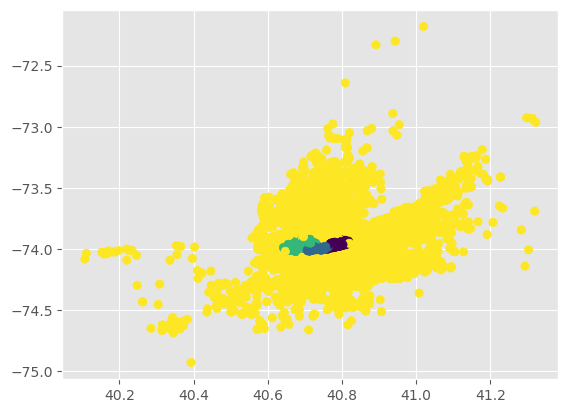

In [ ]:
#plt.scatter(df_new_gmm['Lat'], df_new_gmm['Lon'], c = label_gmm_ori, cmap='viridis');

In [91]:
#Grouping and visualizing the total number of clusters
 
label_fuz_ori = np.argmax(u_ori, axis = 0)
label_fuz_ori

array([2, 3, 2, ..., 3, 3, 4], dtype=int64)

In [94]:
df_new_fuz = uber.copy()
df_new_fuz['Clusters'] = label_fuz_ori
df_new_fuz

,Date/Time,Lat,Lon,Clusters
0,5/1/2014 0:02:00,40.7521,-73.9914,2
1,5/1/2014 0:06:00,40.6965,-73.9715,3
2,5/1/2014 0:15:00,40.7464,-73.9838,2
3,5/1/2014 0:17:00,40.7463,-74.0011,4
4,5/1/2014 0:17:00,40.7594,-73.9734,2
...,...,...,...,...
652430,5/31/2014 23:45:00,40.7309,-74.0014,4
652431,5/31/2014 23:52:00,40.7528,-73.9798,2
652432,5/31/2014 23:55:00,40.7158,-73.9519,3
652433,5/31/2014 23:56:00,40.6961,-73.8997,3


c:\Users\borys\Anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\Users\borys\Anaconda3\lib\site-packages\seaborn\categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


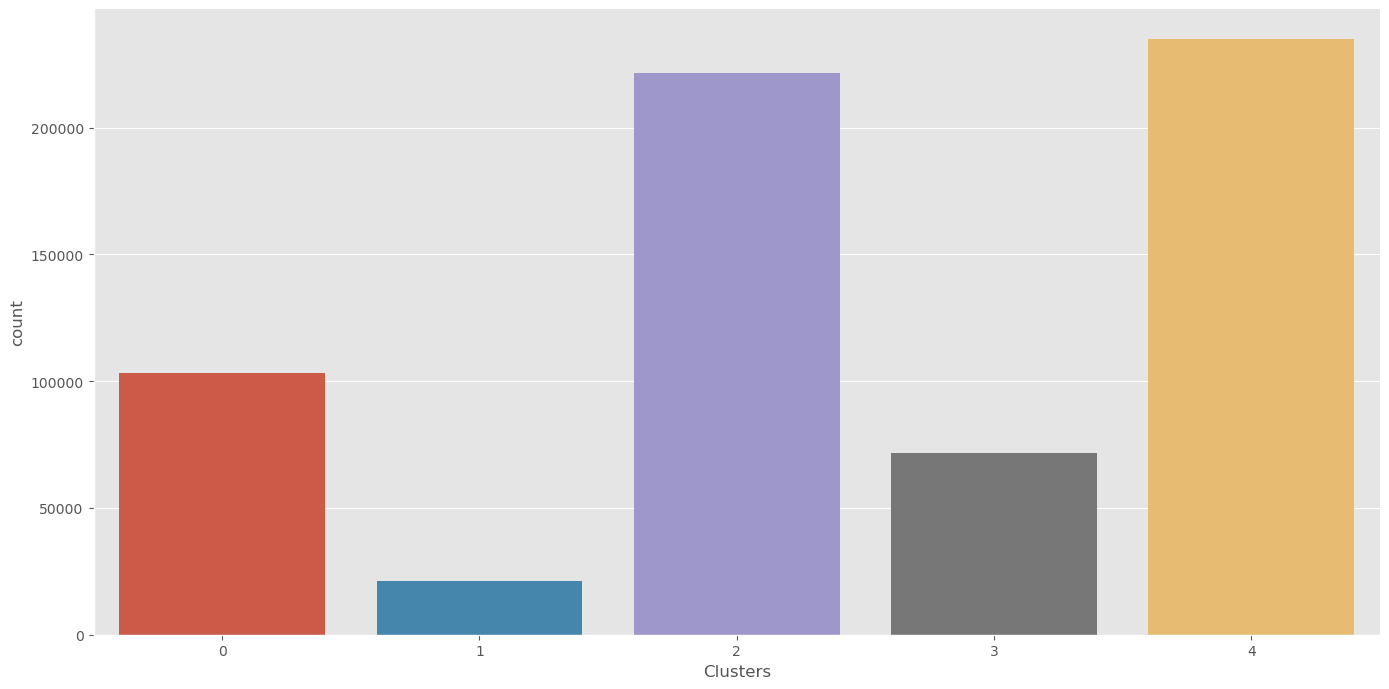

In [97]:
sns.factorplot(data = df_new_fuz, x = "Clusters", kind = "count", size = 7, aspect = 2)

In [101]:
uber.columns

Index(['Date/Time', 'Lat', 'Lon'], dtype='object')

In [120]:
datetime_obj = datetime.strptime(uber['Date/Time'].iloc[0],
                                 "%m/%d/%Y %H:%M:%S")
# extract the time from datetime_obj
hours = datetime_obj.time().hour
print(hours)
uber['Hour'] = uber['Date/Time'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y %H:%M:%S").time().hour)

0


In [127]:
df_new_fuz.columns

Index(['Lat', 'Lon', 'Hour'], dtype='object')

In [128]:
df_new_fuz.dtypes

Lat     float64
Lon     float64
Hour      int64
dtype: object

In [129]:
df_new_fuz.columns

Index(['Lat', 'Lon', 'Hour'], dtype='object')

In [130]:
clus_k_prep = df_new_fuz[['Lat', 'Lon','Hour']]
clus_k_prep.dtypes

Lat     float64
Lon     float64
Hour      int64
dtype: object

In [131]:
kmeans_prep = KMeans(n_clusters = 5, random_state = 0) #k = 3
kmeans_prep.fit(clus_k_prep) 

KMeans(n_clusters=5, random_state=0)

In [140]:
new_location_prep = [(40.7269141,-73.9576251, 12)]
kmeans_prep.predict(new_location_prep)

c:\Users\borys\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


array([2])

In [139]:
new_location_gmm = [(40.7269141,-73.9576251)]
clf.predict(new_location_gmm)

c:\Users\borys\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(


array([1], dtype=int64)